# Library Loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import io
import requests
import gc # Garbage Collector
from scipy.stats import sem, t

# Data Loading and Initial Visualization

Extracted region shape: (100, 100)


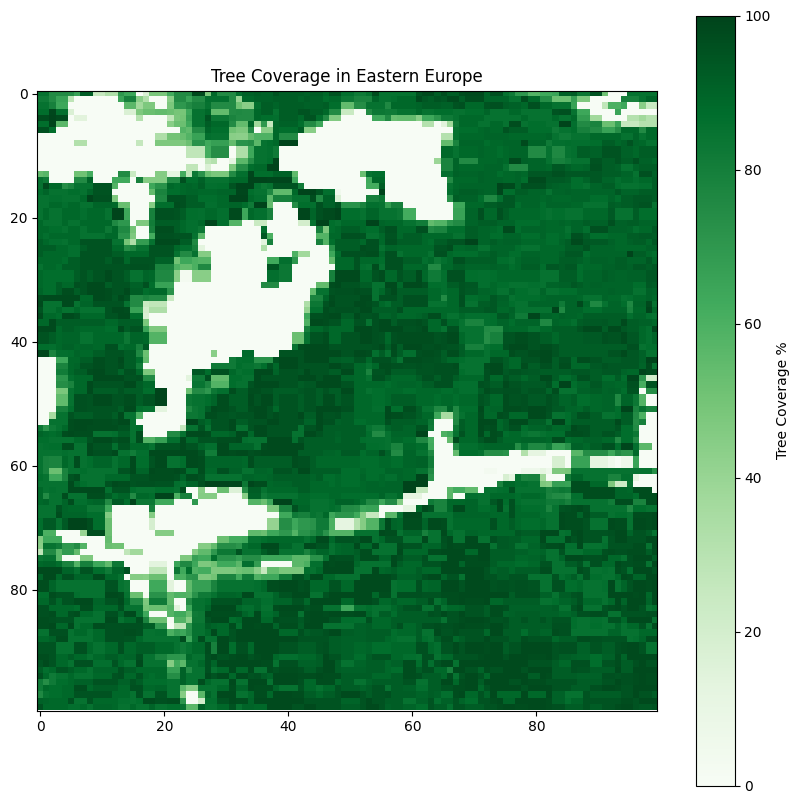

In [3]:
# Specify the URL of the data tile for Belarus
url = (
    'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/'
    'Hansen_GFC-2019-v1.7_treecover2000_50N_020E.tif')

# Instead of loading the entire tile, let's extract just a portion
# First, let's create a function to extract a region of interest
def extract_region(url, start_row, start_col, height, width):
    """
    Extract a region from a large GeoTIFF without loading the entire file.
    """
    # Open the image but don't load all data
    Image.MAX_IMAGE_PIXELS = None
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    # Extract the region of interest
    region = np.array(img.crop((start_col, start_row, start_col + width, start_row + height)))

    # Clean up to free memory
    img.close()
    del response
    gc.collect()

    return region
# named it after my country for fun, it is a prime example of Eastern Europe
# Extract a 300 × 300 region from central Belarus
belarus_region = extract_region(url, 10000, 20000, 100, 100)

# Check the region shape and visualize
print(f"Extracted region shape: {belarus_region.shape}")

plt.figure(figsize=(10, 10))
plt.imshow(belarus_region, cmap='Greens')
plt.colorbar(label='Tree Coverage %')
plt.title("Tree Coverage in Eastern Europe")
plt.show()

forest_data = belarus_region

# Save the forest data to avoid redownloading
np.save('belarus_forest_data.npy', forest_data)

# Forest Fire Simulation Class

In [4]:
class ForestFireSimulation:
    """
    An optimized implementation of a forest fire simulation model for analyzing fire risk.

    This class implements a grid-based Monte Carlo simulation of forest fires, taking into
    account tree density and wind effects. It is optimized for performance using vectorized
    operations and pre-calculations to minimize computational overhead.

    The simulation tracks:
    - Tree density for each cell (0-1 scale)
    - Currently burning cells
    - Cells that have burned
    - Cells affected by fire (burned or adjacent to burned)

    Attributes:
        forest (numpy.ndarray): 2D array of tree density values (0-1)
        height (int)
        width (int)
        burned (numpy.ndarray): Boolean 2D array tracking burned cells
        burning (numpy.ndarray): Boolean 2D array tracking currently burning cells
        affected (numpy.ndarray): Boolean 2D array tracking affected cells
        wind_direction (float): Wind direction in degrees (0=East, 90=North, etc.)
        wind_strength (float): Wind strength (0-1 scale)
        risk_map (numpy.ndarray): 2D array showing probability of each cell being affected
        directions (list)
        wind_effects (dict): Pre-calculated wind effects for each direction
    """

    def __init__(self, forest_data, wind_direction=0, wind_strength=0):
        """
        Initialize the forest fire simulation with tree density data and wind parameters.

        Parameters:
        -----------
        forest_data : numpy.ndarray
            A 2D array with values between 0 and 100 representing tree coverage percentage.
            These values are converted to densities (0-1) internally.

        wind_direction : float, optional (default=0)
            Direction of the wind in degrees (0=East, 90=North, 180=West, 270=South).

        wind_strength : float, optional (default=0)
            Strength of the wind on a scale of 0 to 1, where:
            - 0 means no wind effect
            - 1 means maximum wind effect on fire spread
        """
        # Convert tree coverage percentage (0-100) to density (0-1)
        self.forest = forest_data / 100.0
        self.height, self.width = self.forest.shape

        # Initialize state arrays using boolean type for efficiency
        self.burned = np.zeros_like(self.forest, dtype=bool)  # Cells that have burned
        self.burning = np.zeros_like(self.forest, dtype=bool)  # Cells currently burning
        self.affected = np.zeros_like(self.forest, dtype=bool)  # Cells burned or adjacent to burned

        # Set wind parameters
        self.set_wind(wind_direction, wind_strength)

        # Initialize risk map (will be populated after running simulations)
        self.risk_map = np.zeros_like(self.forest)

        # Pre-calculate wind effects for better performance
        self.precalculate_wind_effects()

    def set_wind(self, direction, strength):
        """
        Set or update the wind parameters for the simulation.

        Parameters:
        -----------
        direction : float
            Wind direction in degrees (0=East, 90=North, 180=West, 270=South).

        strength : float
            Wind strength on a scale of 0 to 1.
        """
        self.wind_direction = direction
        self.wind_strength = strength

        # Convert wind direction from degrees to radians for calculations
        direction_rad = np.radians(direction)

        # Calculate wind vector components for computational use
        self.wind_x = strength * np.cos(direction_rad)
        self.wind_y = strength * np.sin(direction_rad)

    def precalculate_wind_effects(self):
        """
        Pre-calculate wind effects for all 8 cardinal and intercardinal directions.

        This optimization avoids repeated wind effect calculations during simulation steps.
        For each of the 8 possible spread directions, we calculate how much the wind
        enhances or reduces fire spread probability in that direction.

        The calculated effects are stored in the wind_effects dictionary, indexed by direction angle.
        """
        # Define the 8 directions as (row_delta, col_delta) vectors
        # Order: East, Northeast, North, Northwest, West, Southwest, South, Southeast
        self.directions = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]

        # Corresponding angles in degrees for each direction
        direction_angles = [0, 45, 90, 135, 180, 225, 270, 315]

        # Dictionary to store wind effect multipliers for each direction
        self.wind_effects = {}

        # Calculate wind effect for each direction
        for angle in direction_angles:
            # Convert spread direction to radians
            spread_angle_rad = np.radians(angle)

            # Default effect if no wind
            wind_effect = 1.0

            if self.wind_strength > 0:
                # Calculate the angle difference between wind direction and spread direction
                angle_diff = np.abs(np.radians(self.wind_direction) - spread_angle_rad)

                # Normalize to [0, π] - in a circle, the maximum angle difference is π radians
                if angle_diff > np.pi:
                    angle_diff = 2 * np.pi - angle_diff

                # Wind effect is strongest when spreading in the wind direction (angle_diff = 0)
                # and weakest when spreading against the wind (angle_diff = π)
                # Increasing exponential influence
                wind_effect = np.exp(-angle_diff / (np.pi * self.wind_strength))

            # Store the calculated effect
            self.wind_effects[angle] = wind_effect

    def step(self):
        """
        Advance the simulation by one time step, updating the forest fire state.

        This method:
        1. Checks if any cells are currently burning
        2. Attempts to spread fire from burning cells to neighbors
        3. Marks burning cells as burned after they've propagated fire
        4. Updates the affected cells map

        The fire spread probability depends on:
        - The tree density of the target cell
        - Wind direction and strength

        Returns:
        --------
        bool
            True if the fire is still burning (simulation should continue)
            False if the fire has stopped (simulation can end)
        """
        # If nothing is burning, fire has stopped - end simulation
        if not np.any(self.burning):
           return False

        # Create a new array for cells that will be burning after this step
        #new_burning = np.zeros_like(self.burning)

        # Get the coordinates of all currently burning cells
        burning_i, burning_j = np.where(self.burning)

        # Direction angles corresponding to the 8 neighbors
        direction_angles = [0, 45, 90, 135, 180, 225, 270, 315]

        # For each of the 8 directions, process all burning cells at once
        # This vectorization is a key optimization compared to cell-by-cell processing
        for (di, dj), angle in zip(self.directions, direction_angles):
            # Calculate neighbor indices for all burning cells in this direction
            ni = burning_i + di
            nj = burning_j + dj

            # Filter out indices that are outside the grid boundaries
            valid = (0 <= ni) & (ni < self.height) & (0 <= nj) & (nj < self.width)
            ni = ni[valid]
            nj = nj[valid]

            # Skip if no valid neighbors in this direction
            if len(ni) == 0:
                continue

            # Get tree densities for these neighbors
            densities = self.forest[ni, nj]

            # Apply pre-calculated wind effect for this direction
            wind_effect = self.wind_effects[angle]

            # Calculate final spread probabilities, capped at 1.0
            probabilities = np.minimum(1.0, densities * wind_effect * 2) if wind_effect==1 else np.minimum(1.0, densities * wind_effect)

            # Generate random values for all neighbors at once
            random_values = np.random.random(len(ni))

            # Determine which neighbors catch fire based on:
            # 1. Probability check passes
            # 2. Cell is not already burned
            # 3. Cell is not already burning
            # Commenting check for already burning to allow for more spreading
            catch_fire = (random_values < probabilities) & (~self.burned[ni, nj]) & (~self.burning[ni, nj])

            # Set new burning state for cells that catch fire
            if np.any(catch_fire):
                self.burning[ni[catch_fire], nj[catch_fire]] = True

        # Mark currently burning cells as burned
        self.burned[burning_i, burning_j] = True

        # Update burning state to new burning cells
        #self.burning = new_burning

        # Update which cells are affected by the fire
        self.update_affected_cells()

        # Return True if fire is still active
        return np.any(self.burning)

    def update_affected_cells(self):
        """
        Update the 'affected' array to track cells that are burned or adjacent to burned cells.

        This method performs a vectorized operation to mark all cells that are affected by fire,
        which includes:
        1. Cells that have directly burned
        2. Cells that are adjacent (including diagonally) to burned cells

        This information is used to create the risk map showing areas most likely to be affected.
        """
        # Start with all burned cells marked as affected
        self.affected = self.burned.copy()

        # Get coordinates of all burned cells
        burned_i, burned_j = np.where(self.burned)

        # For each of the 8 possible directions (including diagonals)
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                # Skip the center cell (0,0) - it's already marked as burned
                if di == 0 and dj == 0:
                    continue

                # Calculate neighbor indices for all burned cells
                ni = burned_i + di
                nj = burned_j + dj

                # Filter out indices outside grid boundaries
                valid = (0 <= ni) & (ni < self.height) & (0 <= nj) & (nj < self.width)
                ni = ni[valid]
                nj = nj[valid]

                self.affected[ni, nj] = True

    def start_fire(self, i, j):
        """
        Start a fire at the specified location, if possible.

        The fire will only start if the cell contains trees (probability based on tree density).

        Parameters:
        -----------
        i : int
            Row index of the cell to start the fire
        j : int
            Column index of the cell to start the fire

        Returns:
        --------
        bool
            True if fire was successfully started, False otherwise
        """
        # Check if indices are within grid boundaries
        if 0 <= i < self.height and 0 <= j < self.width:
            # Probability of fire starting depends on tree density
            if np.random.random() < self.forest[i, j]:
                self.burning[i, j] = True
                return True
        return False

    def start_random_fire(self):
        """
        Start a fire at a random location with sufficient tree density.

        This method preferentially selects cells with higher tree density (>0.3),
        falling back to any non-zero tree density if necessary.

        Returns:
        --------
        tuple or None
            (row, column) of the fire start location if successful, None otherwise
        """
        # First try to find cells with significant tree density (>0.3)
        potential_cells = np.where(self.forest > 0.3)

        # If no cells with significant density, try any non-zero density
        if len(potential_cells[0]) == 0:
            potential_cells = np.where(self.forest > 0)
            if len(potential_cells[0]) == 0:
                # No suitable cells found
                return None

        # Pick a random cell from the potential candidates
        idx = np.random.randint(0, len(potential_cells[0]))
        i, j = potential_cells[0][idx], potential_cells[1][idx]

        # Try to start fire at this location
        if self.start_fire(i, j):
            return (i, j)
        return None

    def run_simulation(self, max_steps=500):
        """
        Run a complete fire simulation until the fire stops or max_steps is reached.

        Parameters:
        -----------
        max_steps : int, optional (default=500)
            Maximum number of time steps to simulate before stopping

        Returns:
        --------
        numpy.ndarray
            Boolean array indicating which cells were affected by the fire
        """
        step_count = 0

        # Continue until fire stops or max steps reached
        while np.any(self.burning) and step_count < max_steps:
            self.step()
            step_count += 1

        # Used for debugging: affected >= burned
        #print("Burned cells:", np.sum(self.burned))
        #print("Affected cells:", np.sum(self.affected))

        return self.affected

    def run_monte_carlo(self, num_simulations=30, max_steps=500):
        """
        Run multiple simulations with fires starting at random locations.

        This method performs Monte Carlo analysis by:
        1. Running multiple fire simulations with random starting points
        2. Tracking which cells are affected in each simulation
        3. Calculating a risk map showing probability of each cell being affected

        Parameters:
        -----------
        num_simulations : int, optional (default=30)
            Number of Monte Carlo simulations to run

        max_steps : int, optional (default=500)
            Maximum number of steps per individual simulation

        Returns:
        --------
        numpy.ndarray
            2D array with values between 0 and 1 representing the probability of each
            cell being affected by fire (the risk map)
        """
        # Initialize counter for affected cells across all simulations
        affected_count = np.zeros_like(self.forest)
        all_runs_results = [] # We create a list to store the results of each simulation

        # Run multiple simulations
        for sim in range(num_simulations):
            # Reset the simulation state for this run
            self.burned = np.zeros_like(self.forest, dtype=bool)
            self.burning = np.zeros_like(self.forest, dtype=bool)
            self.affected = np.zeros_like(self.forest, dtype=bool)

            # Start a new random fire
            start_pos = self.start_random_fire()
            if start_pos:
                # Run the simulation
                self.run_simulation(max_steps)

                # Update the count of affected cells
                affected_count += self.affected

                all_runs_results.append(self.affected) # Append the result of this simulation to the list
            else:
                all_runs_results.append(self.affected) # If fire fails to start

        # Calculate risk as the probability of being affected (count/total simulations)
        self.risk_map = affected_count / num_simulations

        return self.risk_map, all_runs_results

    def visualize_forest(self):
        """
        Visualize the forest density distribution.

        Creates a color-coded map showing tree density across the forest grid.
        """
        plt.figure(figsize=(10, 10))
        plt.imshow(self.forest, cmap='Greens', vmin=0, vmax=1)
        plt.colorbar(label='Tree Density')
        plt.title('Forest Density Map')
        plt.show()

    def visualize_risk(self):
        """
        Visualize the calculated fire risk map.

        Creates a color-coded map showing the probability of each cell being affected by fire,
        based on the Monte Carlo simulation results.
        """
        plt.figure(figsize=(10, 10))
        plt.imshow(self.risk_map, cmap='YlOrRd', vmin=0, vmax=1)
        plt.colorbar(label='Risk (Probability of being affected)')
        plt.title('Fire Risk Map')
        plt.show()

    def visualize_simulation_state(self):
        """
        Visualize the current state of an ongoing simulation.

        Creates a three-panel figure showing:
        1. Forest density
        2. Current fire state (unburned forest, burning cells, burned cells)
        3. Affected areas

        This is useful for debugging or demonstrating the simulation process.
        """
        plt.figure(figsize=(15, 5))

        # Panel 1: Forest density
        plt.subplot(1, 3, 1)
        plt.imshow(self.forest, cmap='Greens', vmin=0, vmax=1)
        plt.title('Forest Density')
        plt.colorbar()

        # Panel 2: Current fire state
        plt.subplot(1, 3, 2)
        # Create a composite RGB image:
        rgb = np.zeros((self.height, self.width, 3))
        rgb[:, :, 1] = self.forest * (~self.burned) * (~self.burning)  # Green for unburned forest
        rgb[:, :, 0] = self.burning.astype(float)  # Red for burning cells
        plt.imshow(rgb)
        plt.title('Current Fire State')

        # Panel 3: Affected areas
        plt.subplot(1, 3, 3)
        plt.imshow(self.affected, cmap='Reds')
        plt.title('Affected Areas')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

# Controlled Fire Test

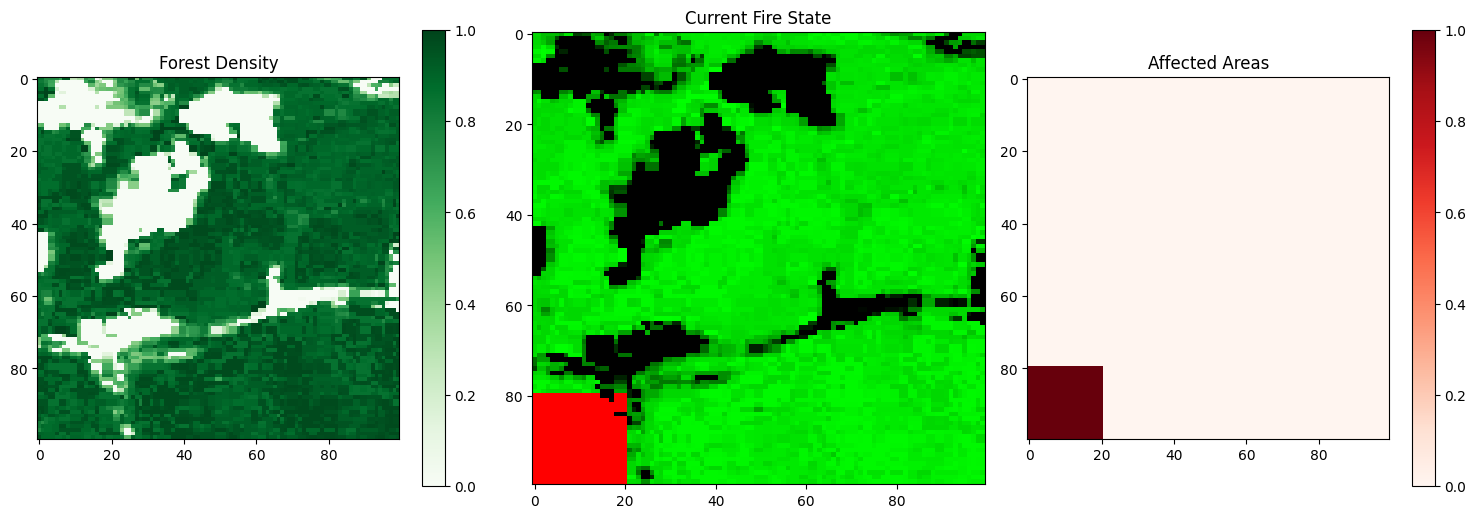

In [5]:
simulation = ForestFireSimulation(forest_data, wind_direction=0, wind_strength=0)
simulation.start_fire(90, 10)
simulation.run_simulation(max_steps=10)
simulation.visualize_simulation_state()

# Monte Carlo Simulation and Risk Assessment

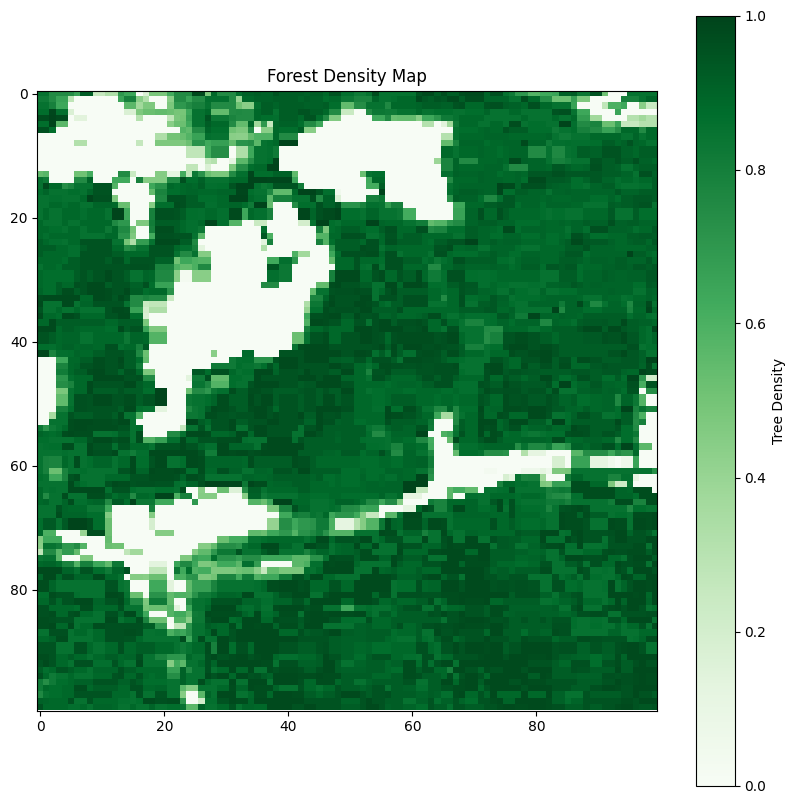

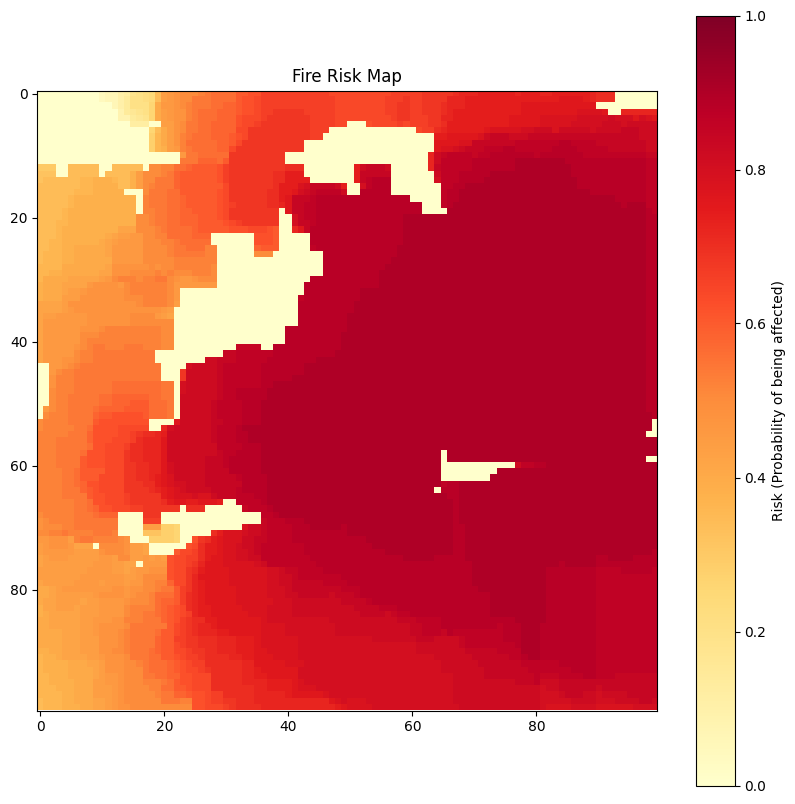

In [6]:
# Load the saved forest data
forest_data = np.load('belarus_forest_data.npy')

# Create the simulation East
simulation = ForestFireSimulation(forest_data, wind_direction=0, wind_strength=0.5)

# Visualize the forest
simulation.visualize_forest()

# Run Monte Carlo simulation with fewer iterations to stay within memory constraints
risk_map1, all_runs1 = simulation.run_monte_carlo(num_simulations=50, max_steps=100)

# Visualize the risk map
simulation.visualize_risk()

# Wind Scenario Comparison

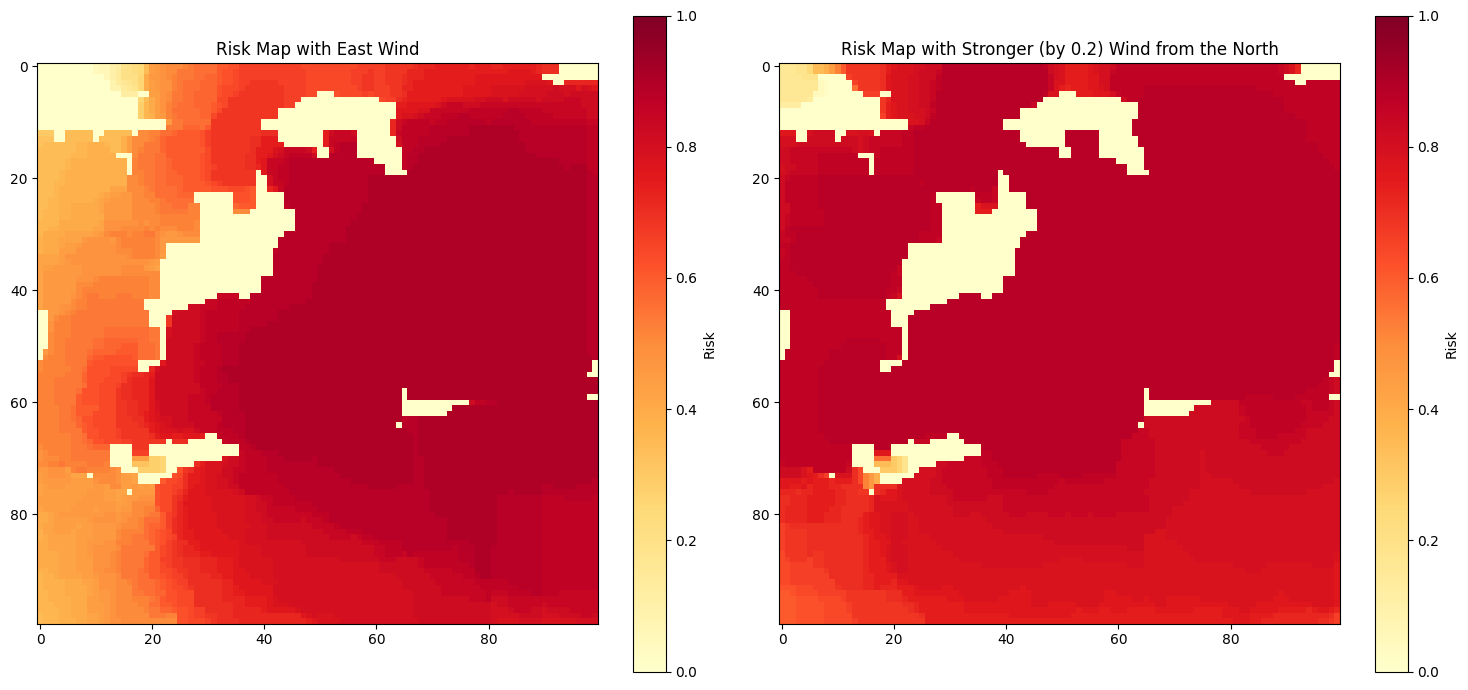

Average risk with East Wind: 0.6919
Average risk with North Wind: 0.7615
Average risk with East Wind: 0.6919 ± 0.0988
Average risk with North Wind: 0.7615 ± 0.0943


In [7]:
# Try another wind scenario North
simulation2 = ForestFireSimulation(forest_data, wind_direction=90, wind_strength=0.7)
risk_map2, all_runs2 = simulation2.run_monte_carlo(num_simulations=50, max_steps=100)

# Compare the risk maps
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(risk_map1, cmap='YlOrRd', vmin=0, vmax=1)
plt.colorbar(label='Risk')
plt.title('Risk Map with East Wind')

plt.subplot(1, 2, 2)
plt.imshow(risk_map2, cmap='YlOrRd', vmin=0, vmax=1)
plt.colorbar(label='Risk')
plt.title('Risk Map with Stronger (by 0.2) Wind from the North')

plt.tight_layout()
plt.show()

# Calculate some statistics for comparison
avg_risk1 = np.mean(risk_map1)
avg_risk2 = np.mean(risk_map2)

print(f"Average risk with East Wind: {avg_risk1:.4f}")
print(f"Average risk with North Wind: {avg_risk2:.4f}")

def compute_confidence_interval(all_runs):
    # Convert the list of arrays to a 3D NumPy array
    all_runs_array = np.stack(all_runs)
    # Calculate the mean across all simulations for each cell
    mean = np.mean(all_runs_array, axis=0)
    # Calculate standard error of the mean for each cell
    ci = sem(all_runs_array, axis=0) * t.ppf(0.975, df=all_runs_array.shape[0] - 1)

    # Calculate avrg mean and CI across all cells
    avg_mean = np.mean(mean)
    avg_ci = np.mean(ci)
    return avg_mean, avg_ci

mean1, ci1 = compute_confidence_interval(all_runs1)
mean2, ci2 = compute_confidence_interval(all_runs2)

print(f"Average risk with East Wind: {np.mean(mean1):.4f} ± {np.mean(ci1):.4f}")
print(f"Average risk with North Wind: {np.mean(mean2):.4f} ± {np.mean(ci2):.4f}")

# Fire Break Experiment

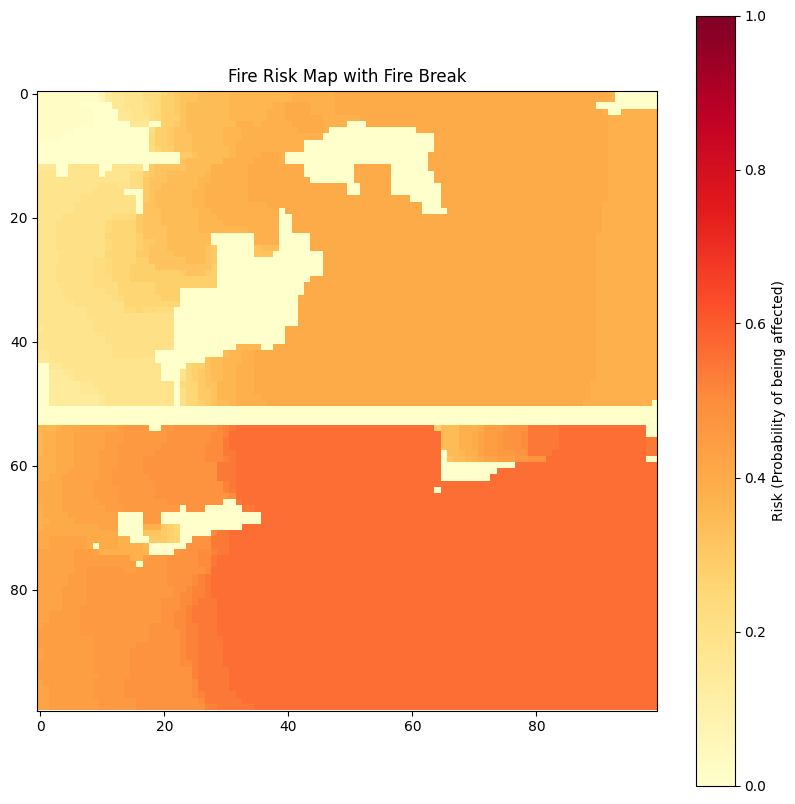

Average risk before fire break: 0.6919
Average risk after fire break: 0.3868
Percentage reduction in risk: 44.09%


In [8]:
# Create a copy of the forest data for modification
forest_with_break = forest_data.copy()

# Create a fire break by setting tree density to 0 in a horizontal strip
# You can adjust the position and width of the fire break as needed
break_row_start = 50  # Starting row for the fire break
break_row_end = 55  # Ending row for the fire break
forest_with_break[break_row_start:break_row_end, :] = 0  # Set tree density to 0

# Create a simulation object using the modified forest data
simulation_break = ForestFireSimulation(forest_with_break, wind_direction=0, wind_strength=0.5)

# Run the Monte Carlo simulation with the fire break
risk_map_break, all_runs_break = simulation_break.run_monte_carlo(num_simulations=50, max_steps=100)

# Visualize the risk map with the fire break
plt.figure(figsize=(10, 10))
plt.imshow(risk_map_break, cmap='YlOrRd', vmin=0, vmax=1)
plt.colorbar(label='Risk (Probability of being affected)')
plt.title('Fire Risk Map with Fire Break')
plt.show()

# Calculate average risk before and after fire break
avg_risk_before = np.mean(risk_map1)  # risk_map1 from original simulation
avg_risk_after = np.mean(risk_map_break)

# Calculate percentage reduction in risk
risk_reduction = ((avg_risk_before - avg_risk_after) / avg_risk_before) * 100

# Print the results
print(f"Average risk before fire break: {avg_risk_before:.4f}")
print(f"Average risk after fire break: {avg_risk_after:.4f}")
print(f"Percentage reduction in risk: {risk_reduction:.2f}%")

# Histogram Comparison

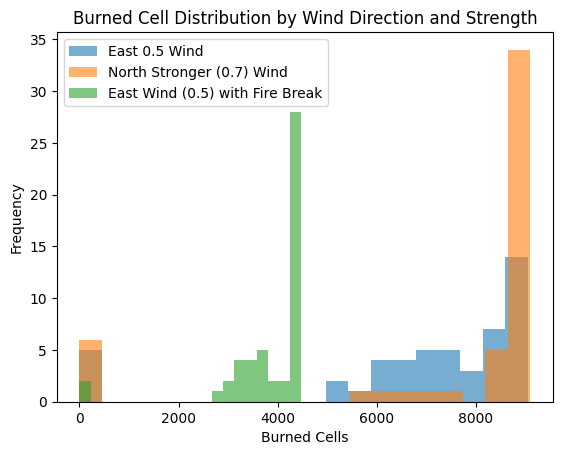

In [9]:
# Histogram of burn counts
plt.hist([np.sum(r) for r in all_runs1], bins=20, alpha=0.6, label='East 0.5 Wind')
plt.hist([np.sum(r) for r in all_runs2], bins=20, alpha=0.6, label='North Stronger (0.7) Wind')
plt.hist([np.sum(r) for r in all_runs_break], bins=20, alpha=0.6, label='East Wind (0.5) with Fire Break')
plt.legend()
plt.title("Burned Cell Distribution by Wind Direction and Strength")
plt.xlabel("Burned Cells")
plt.ylabel("Frequency")
plt.show()

Testing density: 0.10
  Mean burn percentage: 0.0004, Std dev: 0.0003
Testing density: 0.20
  Mean burn percentage: 0.0011, Std dev: 0.0006
Testing density: 0.30
  Mean burn percentage: 0.0022, Std dev: 0.0012
Testing density: 0.40
  Mean burn percentage: 0.0039, Std dev: 0.0014
Testing density: 0.50
  Mean burn percentage: 0.0053, Std dev: 0.0023
Testing density: 0.60
  Mean burn percentage: 0.0083, Std dev: 0.0028
Testing density: 0.70
  Mean burn percentage: 0.0123, Std dev: 0.0036
Testing density: 0.80
  Mean burn percentage: 0.0169, Std dev: 0.0044
Testing density: 0.90
  Mean burn percentage: 0.0213, Std dev: 0.0062
Testing density: 1.00
  Mean burn percentage: 0.0268, Std dev: 0.0058


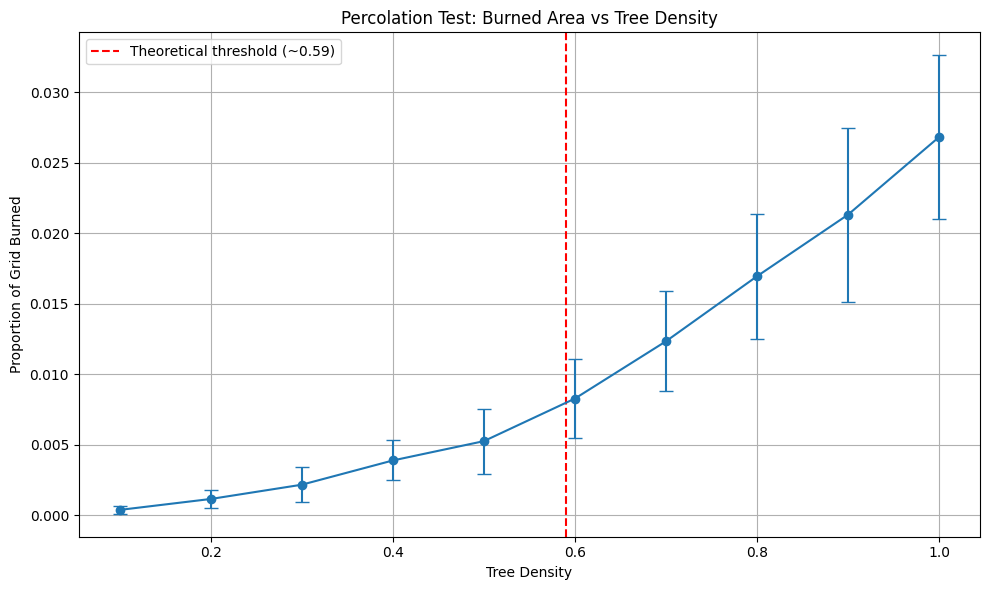


Estimated percolation threshold: 1.0000
Theoretical threshold for 2D square lattice: ~0.59


In [10]:
def test_percolation_threshold():
    """
    Test that the forest fire model correctly exhibits percolation threshold behavior.
    Theory predicts a critical threshold around 0.59 for a 2D square lattice.
    """
    # Range of densities to test
    densities = np.linspace(0.1, 1, 10)
    grid_size = 100
    trials_per_density = 50  # Run multiple trials at each density

    # Store results
    results = []

    for density in densities:
        print(f"Testing density: {density:.2f}")

        # Run multiple trials at this density
        burn_percentages = []
        for trial in range(trials_per_density):
            # Create uniform density grid
            test_grid = np.ones((grid_size, grid_size)) * density

            # Initialize simulation with no wind
            sim = ForestFireSimulation(test_grid, wind_direction=0, wind_strength=0)

            # Start fire in the center
            center = grid_size // 2
            sim.burning[center, center] = True # Force fire to start

            # Run simulation
            sim.run_simulation(max_steps=100)

            # Calculate percentage of grid burned
            # Use sim.burned instead of sim.burned_cells
            burn_percent = np.sum(sim.burned) / (grid_size * grid_size)
            burn_percentages.append(burn_percent)

        # Calculate statistics for this density
        mean_burn = np.mean(burn_percentages)
        std_burn = np.std(burn_percentages)

        results.append((density, mean_burn, std_burn))
        print(f"  Mean burn percentage: {mean_burn:.4f}, Std dev: {std_burn:.4f}")

    # Extract data for plotting
    density_values = [r[0] for r in results]
    mean_values = [r[1] for r in results]
    std_values = [r[2] for r in results]

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.errorbar(density_values, mean_values, yerr=std_values,
                 marker='o', linestyle='-', capsize=5)
    plt.axvline(x=0.59, color='r', linestyle='--',
                label='Theoretical threshold (~0.59)')

    plt.title("Percolation Test: Burned Area vs Tree Density")
    plt.xlabel("Tree Density")
    plt.ylabel("Proportion of Grid Burned")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('percolation_threshold_test.png')
    plt.show()

    # Find the experimental threshold (where burn percentage is closest to 0.5)
    mean_values_array = np.array(mean_values)
    threshold_idx = np.argmin(np.abs(mean_values_array - 0.5))  # Find index closest to 0.5
    estimated_threshold = density_values[threshold_idx]
    print(f"\nEstimated percolation threshold: {estimated_threshold:.4f}")
    print(f"Theoretical threshold for 2D square lattice: ~0.59")

    return results
# Call the function to get the results
results = test_percolation_threshold() # This line is added to call the function and assign the returned value to 'results'